In [1]:
include("ready.jl")

┌ Warning: Message type 'Bool' conflicts with Julia builtin, will be imported as 'BoolMsg'
└ @ RobotOS /home/yangbo/.julia/packages/RobotOS/j0Tsl/src/gentypes.jl:181
┌ Warning: Message type 'Float64' conflicts with Julia builtin, will be imported as 'Float64Msg'
└ @ RobotOS /home/yangbo/.julia/packages/RobotOS/j0Tsl/src/gentypes.jl:181



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

complete initialization


In [2]:
β_controller = PID(Kp=0.5, Ki=0.00005, Kd=30, sign=1)
R_controller = PID(Kp=0.5, Ki=0.005, Kd=0.05, sign=-1)
phase = 1
t1 = 0
t12 = 0

function control_fn!(i, state, exstate, reference)
    global phase
    global t1
    global t12
    
    reference.R_ref = 0.9
    
    δ = 0
    ω = 0
    β = exstate.β
    R = exstate.R
    R_ref = reference.R_ref
    β_ref = reference.β_ref
    
    β_ff = -1.35
    
    if i % 100 == 1
        # outer-loop control
        if phase == 3 && abs(R - R_ref) <= 0.2
            phase = 4
        end
        if phase == 4 && abs(R - R_ref) > 0.2
            phase = 3
        end
        err = R - R_ref
        if phase < 3
            β_ref = β_ff
        else
            β_ref = clamp(β_ff + controla!(R_controller, err), -2.4, 0)
            if phase == 3
                # do not use integral when R is large at the initial phase
                R_controller.err_sum = 0
            end
        end
        reference.β_ref = β_ref
    end
    
    reference.β_ref = β_ref

    err = round_angle(β - β_ref)
    if phase == 1
        δ = π / 8
        ω = 5.0
        if β < -0.8
            phase = 2
            t1 = i
        end
    elseif phase == 2
        δ = -π / 8
        ω = 5.0
        if β < -1.1
            phase = 3
            t12 = i
        end
    else    
        δ = clamp(0.1 + controla!(β_controller, err), -0, π / 8)
        ω = 5.0
    end
    return δ, ω
end

function reset_fn()
    β_controller.err_sum = 0
    β_controller.last_err = 0
    R_controller.err_sum = 0
    R_controller.last_err = 0
    phase = 1
end

reset_fn (generic function with 1 method)

In [3]:
init_node("Controller", disable_signals=true)
sub1 = Subscriber{RosMsg.PoseStamped}("/vrpn_client_node/racecar/pose", update_rts, queue_size=1)
sub2 = Subscriber{RosMsg.Imu}("/imu", update_imu, queue_size=1)
sub3 = Subscriber{RosMsg.BoolMsg}("/Safe", update_safe, queue_size=1)
pub = Publisher{RosMsg.VescCtrlStamped}("/vesc/ctrl", queue_size=1)
data = control_wrapper(pub, control_fn!, reset_fn);

Interrupted


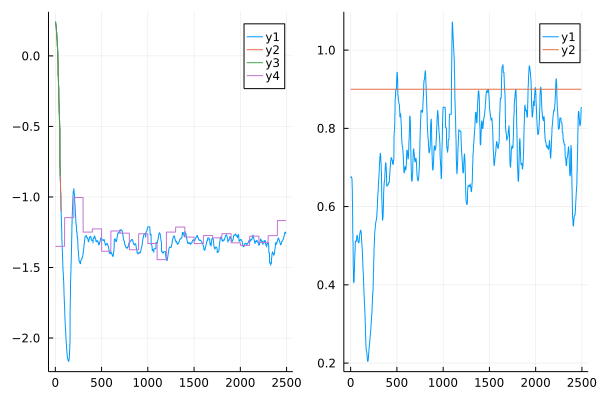

In [34]:
using Plots

p1 = plot([p.es.β for p in data])
plot!([p.es.β for p in data[1:t12]])
plot!([p.es.β for p in data[1:t1]])
plot!(p1, [p.ref.β_ref for p in data])
p2 = plot([p.u.δ for p in data])
p3 = plot([p.es.R for p in data])
plot!(p3, [p.ref.R_ref for p in data])
plot(p1, p3)

In [35]:
save("data_r0.9.jld", "data", data)

In [38]:
data_r05 = load("data_r0.5.jld")["data"];
data_r06 = load("data_r0.6.jld")["data"];
data_r07 = load("data_r0.7.jld")["data"];
data_r08 = load("data_r0.8.jld")["data"];
data_r09 = load("data_r0.9.jld")["data"];
data_r1 = load("data_r1.jld")["data"];

In [39]:
using Statistics
@show mean([p.es.R for p in data_r05[end-500:end]])
@show mean([p.es.R for p in data_r06[end-500:end]])
@show mean([p.es.R for p in data_r07[end-500:end]])
@show mean([p.es.R for p in data_r08[end-500:end]])
@show mean([p.es.R for p in data_r09[end-500:end]])
@show mean([p.es.R for p in data_r1[end-500:end]])

mean([p.es.R for p = data_r05[end - 500:end]]) = 0.5898192077165109
mean([p.es.R for p = data_r06[end - 500:end]]) = 0.5966427529778243
mean([p.es.R for p = data_r07[end - 500:end]]) = 0.6649745080270192
mean([p.es.R for p = data_r08[end - 500:end]]) = 0.7529163738856264
mean([p.es.R for p = data_r09[end - 500:end]]) = 0.7751123621685267
mean([p.es.R for p = data_r1[end - 500:end]]) = 0.9149310012672462


0.9149310012672462

In [41]:
@show mean([p.es.β for p in data_r05[end-500:end]])
@show mean([p.es.β for p in data_r06[end-500:end]])
@show mean([p.es.β for p in data_r07[end-500:end]])
@show mean([p.es.β for p in data_r08[end-500:end]])
@show mean([p.es.β for p in data_r09[end-500:end]])
@show mean([p.es.β for p in data_r1[end-500:end]])

mean([p.es.β for p = data_r05[end - 500:end]]) = -1.3688720878775653
mean([p.es.β for p = data_r06[end - 500:end]]) = -1.3681965906748585
mean([p.es.β for p = data_r07[end - 500:end]]) = -1.3480274550884035
mean([p.es.β for p = data_r08[end - 500:end]]) = -1.3228786242943313
mean([p.es.β for p = data_r09[end - 500:end]]) = -1.3298512899093788
mean([p.es.β for p = data_r1[end - 500:end]]) = -1.286722076831964


-1.286722076831964

In [42]:
@show mean([p.u.δ for p in data_r05[end-500:end]])
@show mean([p.u.δ for p in data_r06[end-500:end]])
@show mean([p.u.δ for p in data_r07[end-500:end]])
@show mean([p.u.δ for p in data_r08[end-500:end]])
@show mean([p.u.δ for p in data_r09[end-500:end]])
@show mean([p.u.δ for p in data_r1[end-500:end]])

mean([p.u.δ for p = data_r05[end - 500:end]]) = 0.11969545600894464
mean([p.u.δ for p = data_r06[end - 500:end]]) = 0.10651775698236136
mean([p.u.δ for p = data_r07[end - 500:end]]) = 0.11404074991547401
mean([p.u.δ for p = data_r08[end - 500:end]]) = 0.10623398848872308
mean([p.u.δ for p = data_r09[end - 500:end]]) = 0.09022900831367459
mean([p.u.δ for p = data_r1[end - 500:end]]) = 0.11922845926928517


0.11922845926928517